#### We include a few other basic tools for filtering, tapering, and cleaning the data. Examples below: 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

#-- To import a function on a relative path:
import sys
sys.path.append("../")
from pydas_readers.readers import load_das_h5
from pydas_readers.util import block_filters, block_cleaning


# Load Data

In [2]:
t_start = datetime.strptime('2021/10/12 09:24:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2021/10/12 09:25:40.0', '%Y/%m/%d %H:%M:%S.%f') 

#-- Load
input_dir = "./example_data_Athens/data_raw_epoch2/"
data_raw, headers, axis = load_das_h5.load_das_custom(t_start, t_end, 
                                                      d_start=0, d_end=5000,
                                                      input_dir = input_dir, verbose=False)

t0 = headers['t0']
t1 = headers['t1']
lx = headers['lx']
fs = headers['fs']


# Example Pre-processing

In [3]:

#-- Detrend 
#--  Not usually needed for DAS data, but it's quite fast and good practice.
data = block_cleaning.detrend(data_raw, type='linear')

#-- Taper
#-- Either call directly with 
data = block_cleaning.taper(data_raw,0.02)
#--  or when filtering with "taper=0.02" (e.g., 2%)
 
    
#-- Bandpass Filter (and taper)
f1 = 0.1
f2 = 15.0
data = block_filters.block_bandpass(data, f1, f2, fs, zerophase=False, taper=0.02)
print("   Filtering completed")

#-- Trim: Pass new datetime objects and cut down the data block accordingly.
#--    "headers" dict must be passed and will be updated.
#--    "axis" object is optional, but will be updated if given.
#--    TODO: Instead of datetimes, design function to recognize relative seconds
#--    TODO: Add a trim option for distance axis instead of only time 
tc0 = datetime.strptime('2021/10/12 09:25:00.0', '%Y/%m/%d %H:%M:%S.%f')
tc1 = datetime.strptime('2021/10/12 09:25:30.0', '%Y/%m/%d %H:%M:%S.%f')
data_trim, headers_trim, axis_trim = block_cleaning.trim(data, tc0, tc1, headers, axis)


Filtering 0.1Hz to 15.0Hz
   Filtering completed


# Quick plot

In [12]:
#-- Define a plotting function

#-- (Easier to define such a function in-notebook rather than in a loaded function, 
#--    since updating labels or colorbars is easier)

def waterfall_plot(data,headers, vmax=120):
    dx = headers['dx']
    fm = headers['fm']
    d0 = headers['d0']
    fs = headers['fs']

    plt.rcParams.update({'font.size': 14})

    plt.figure(figsize=(15,8))
    ax = plt.gca()

    plt.imshow(data.T, aspect="auto", cmap='seismic', interpolation='antialiased', 
            extent=(0,headers["npts"]/headers["fs"], headers["d1"]/1000,headers["d0"]/1000),
            vmin=-vmax, vmax=vmax)

    plt.colorbar(label="Optical Intensity")
    plt.xlabel("Time [s] after  "+ datetime.strftime(headers["t0"], format='%Y/%m/%d %H:%M:%S.%f'))
    plt.ylabel("Distance [km]")
    plt.title("{0}, filtered {1} to {2} Hz".format(headers["t0"].strftime('%Y/%m/%d %H:%M:%S'),f1,f2))
    ax.invert_yaxis()

# plt.savefig("example_figure.png",bbox_inches="tight")
plt.show()


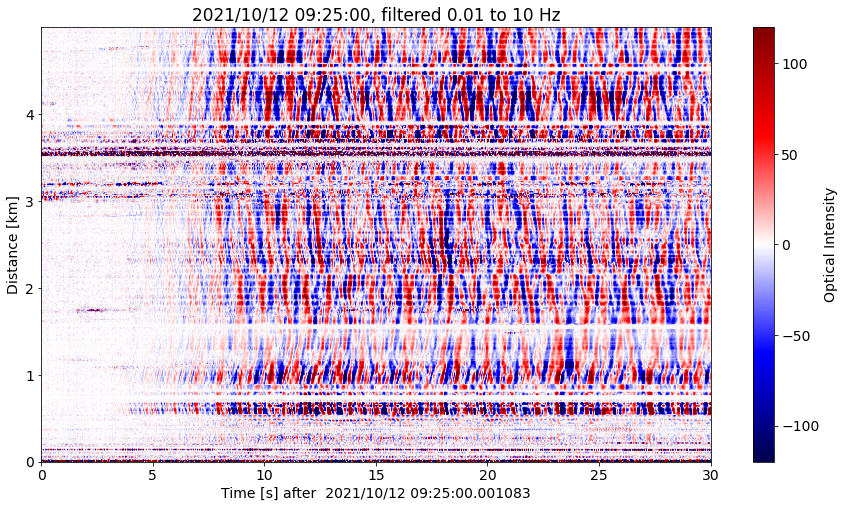

In [13]:
waterfall_plot(data_trim, headers_trim)



## Taking it further: Phase-weighted rolling average to clean incoherent signals

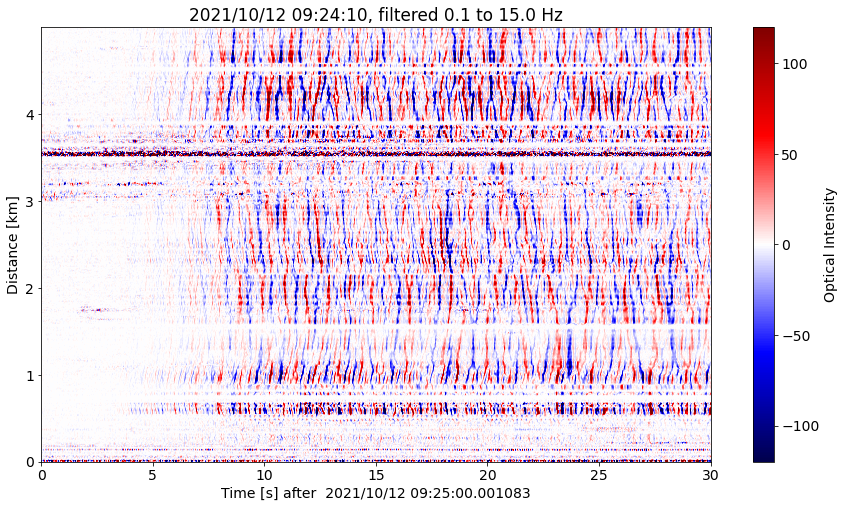

In [6]:
data_pws = block_cleaning.pws_rolling_average(data_trim,4)
waterfall_plot(data_pws, headers_trim)



## BONUS: what is the PWS doing?
### ("Bonus" because this is no longer demonstrating -how- to use functions, but instead exploring a bit how it works)

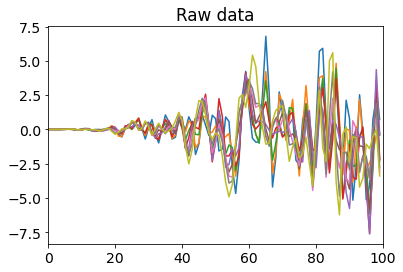

/home/danielb/miniconda3/envs/das/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


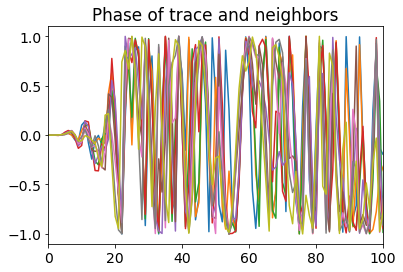

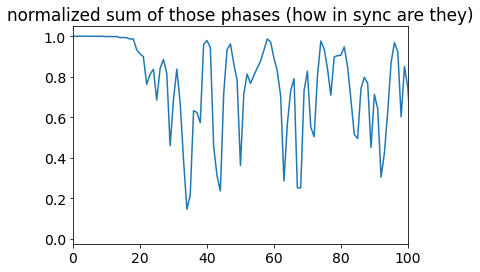

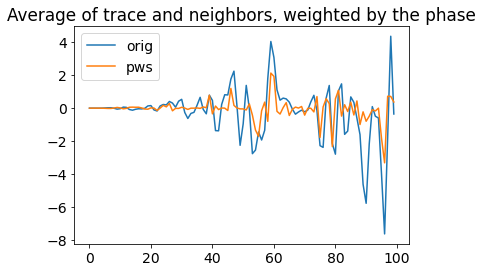

In [7]:
from scipy.signal import hilbert


data_pws = np.zeros(np.shape(data))

#-- Define how many traces before AND after we will average
ns = 4
#-- Define an example single trace to look at
i = 500

plt.plot(data[0:100,i-ns:i+ns+1])
plt.title('Raw data')
plt.xlim([0,100])
plt.show()


#-- hilbert transform: abs() gives envelope and we can also get phase
dh = hilbert(data[:,i-ns:i+ns+1],axis=0)

#-- Instantaneous phase:
plt.plot(dh/np.abs(dh))
plt.xlim([0,100])
plt.title('Phase of trace and neighbors')
plt.show()

#-- Sum the phases: higher abs(pw) means more "in sync"
pw = np.mean(dh/np.abs(dh),axis=1)
plt.plot(np.abs(pw))
plt.xlim([0,100])
plt.title('normalized sum of those phases (how in sync are they)')
plt.show()

#-- Average the traces, weighted more strongly by places where the phases were in sync
#--  (i.e., signals in any places out of sync get pushed towards zero)
data_pws[:,i] = np.real(pw**2 * np.mean(data[:,i-ns:i+ns+1],axis=1))
plt.plot(data[0:100,i],label='orig')
plt.plot(data_pws[0:100,i],label='pws')
plt.legend()
plt.title('Average of trace and neighbors, weighted by the phase')
plt.show()



#-- In this example, traces near t=60 samples were somewhat synchronized, and so this remains in the 
#--  final stack. Traces near t=90 are more chaotic, so this is noise we (might) want to downweight


## BONUS: Know your filters! (Know what they're doing)

In [8]:
from scipy import signal

#############################################################################
## The butterworth filter that most seismologists use is fairly gentle.
## It surpresses frequencies outside the deired range but tapers them only slowly
## And the tapering starts OUTSIDE the range of interest, so your main frequencies are untampered with
f1 = 0.01
f2 = 10
fs = headers['fs']
data_filtered_butterworth = block_filters.block_bandpass(data_raw, f1, f2, fs, corners=8, zerophase=False)
# higher corners = sharper. So corners = 8 is sharper even than usual! Default is 4 for many programs.

#############################################################################
## In contrast the Chebyshev filter used in downsampling is quite sharp:
## We want to be absolutely certain that no frequencies exist above some limit, to avoid aliasing,
##  so it starts tapering BEFORE that limit
## (copied from downsample function)
rp, rs, order = 1, 96, 1e99
ws = f2 / (fs * 0.5)  # stop band frequency
wp = ws  # pass band frequency

while True:
    if order <= 12:
        break
    wp *= 0.99
    order, wn = signal.cheb2ord(wp, ws, rp, rs, analog=0)
sos = signal.cheby2(order, rs, wn, btype='low', analog=0, output='sos')
data_filtered_cheb = np.zeros( np.shape(data_raw) )

for i in range(np.shape(data_raw)[1]):
    data_filtered_cheb[:,i] = signal.sosfilt(sos, data_raw[:,i])


Filtering 0.01Hz to 10Hz


In [9]:
#-- We'll make a tool, to look at each spectra:

def amp_spectra(d,fs):
    """
    xf, spectra = amp_spectra(data[:,i], headers['fs'])
    
    Quick function to take an fft and compute x-axis of frequencies
    
    There's many ways to do this:
      - Use scipy functions
      - Use fft() and then roll() to get the correct part
      - Use rfft() 
    I also precompute NFFT as a power of 2, which is computationally better
     for Fortran and C. Probably this is unnecessary now with internal checks
     within numpy, but I wanted to be consistent.

    :param d: 1D numpy array
    :param fs: sample rate in Hz
    :return: xf, spectra
    """
    npts = len(d)
    delta = 1/fs
    nfft = (2.0**np.round(np.log2(npts))).astype(int)
    df = 1.0/(2*nfft*delta)
    xf = np.linspace(0.0, 1.0/(2.0*delta), int((nfft/2)+1))
    spectra = np.fft.rfft(d,n=nfft)
    return xf, spectra



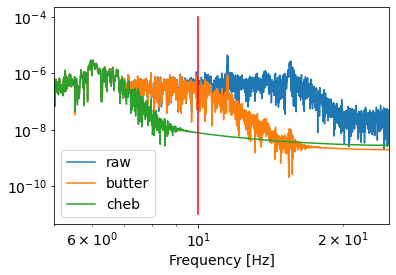

In [10]:
xf, spectra = amp_spectra(data_raw[:,200], headers['fs'])
plt.loglog(xf, np.abs(spectra)/1e9,  label='raw')

xf, spectra = amp_spectra(data_filtered_butterworth[:,200], headers['fs'])
plt.loglog(xf, np.abs(spectra)/1e9,  label='butter')

xf, spectra = amp_spectra(data_filtered_cheb[:,200], headers['fs'])
plt.loglog(xf, np.abs(spectra)/1e9,  label='cheb')

## Plot lines where the spectra is ostensibly filtered
plt.plot([f2,f2], [1e-11, 1e-4], 'r')
plt.xlim([5,25])
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

